A workflow for flagging unusually long repeat expansions in samples.
1. Get the observed repeat lengths from a set of samples in a TRGTdb to serve as a control
2. Identify repeat lengths in another set of case samples which are significantly longer relative to controls
3. Output the resulting list of potentially significant loci and generate some example summary plots

The first example will perform the query when our case samples are mereged into the same database as the controls.

In [1]:
import trgt
import pandas as pd

In [3]:
data = trgt.load_tdb("../test_files/databases/hprc_105.tdb/")
print("TRGTdb sample count:", len(data["sample"]))

TRGTdb sample count: 105


If your sample of interest is in a VCF and not converted / merged into the database of controls, you can create an in-memory consolidated data based via:
```python
new_sample = trgt.vcf_to_tdb("SampleABC.vcf.gz")
# Note that this creates the database in-memory. Therefore, no `.tdb` files are altered
merged_database = trgt.tdb_consolidate(data, new_sample)
```

Now that our data is ready, we'll need to identify our case sample to separate it from the and 'control' samples. For this example, we'll just use HG002 as the case and the rest are controls.

In [6]:
case = "HG002"
controls = [_ for _ in data["sample"].keys() if _ != case]

Next, we'll pull the observed allele lengths for our samples.

In [36]:
# Only need to do this once so we can quickly grab the subset of alleles for each sample table
alleles = data["allele"].set_index(["LocusID", "allele_number"])

def get_observed_allele_lengths(data, samples):
    """
    Given a TRGTdb and a list of sample names
    return a DataFrame of LocusID, allele_number, allele_length, sample_name
    """
    observed_allele_lengths = []
    for name in samples:
        sample_table = data["sample"][name]
        
        # Create an index of the alleles present in the sample
        idx_table = pd.MultiIndex.from_frame(sample_table[["LocusID", "allele_number"]])
        # Subset the alleles and pull their lengths
        result = alleles.loc[idx_table, ["allele_length"]]
        result['sample_name'] = name
        observed_allele_lengths.append(result)
    # Sorting and indexing here speeds up calculating the distribution pre-locus later
    return (pd.concat(observed_allele_lengths)
                .reset_index()
                .sort_values("LocusID")
                .set_index("LocusID"))

# Create case/control observed allele lengths
control_allele_lengths = get_observed_allele_lengths(data, controls)

# Some loci only have a single observed allele (homozygous sites)
# We can `drop_duplicates` to remove the redundant information
case_allele_lengths = get_observed_allele_lengths(data, [case]).drop_duplicates()

# Quick little summary stats
print(f"Observed {len(case_allele_lengths):,} alleles in case over {case_allele_lengths.index.nunique():,} loci")
print(f"Observed {len(control_allele_lengths):,} alleles in {len(controls):,} controls over {control_allele_lengths.index.nunique():,} loci")

Observed 1,866,940 alleles in case over 935,231 loci
Observed 194,000,042 alleles in 104 controls over 937,017 loci


For every locus, we want to calculate the observed distribution of allele lengths which we'll be testing against. Here we'll simply calculate the mean and standard deviation. If you have a custom method, switch the `.describe` to `.apply(your_method)`

In [34]:
def calculate_distribution(observed_allele_lengths):
    """
    return a DataFrame with mean, standard deviation (std), and upper_threshold of (mean + 3 std) for each locus
    """
    grp = observed_allele_lengths.groupby("LocusID")["allele_length"]
    length_distribution = pd.concat([grp.mean(), grp.std()], axis=1)
    length_distribution.columns = ["mean", "std"]
    length_distribution['upper_threshold'] = length_distribution['mean'] + length_distribution['std'] * 3
    return length_distribution

control_distro = calculate_distribution(control_allele_lengths)

Note that pulling the allele lengths and calculating the distribution is slow since there are so many loci. If you plan on performing tests against the `control_distro` multiple times, you may want to save its DataFrame and load it later for reuse. Another optimization could be to limit the number of loci that need their distribution calculated by e.g. subsetting to only loci with a minimum number of non-reference alleles.

We can now join the two distributions and compare. As an example, we'll look for loci where the case allele length is above the control upper_threshold.

In [44]:
distros = case_allele_lengths.join(control_distro)
loci_test = distros['allele_length'] > distros['upper_threshold']
print("Number of loci passing test:")
loci_test.value_counts()

Number of loci passing test:


False    12005
True       135
dtype: int64

To make a final report, we'll subset the `case_allele_lengths` to loci passing the test, join back to the Locus table so we have location information, and add a 'z-score' to the report before saving to a tsv.

In [48]:
report = distros[loci_test].copy() # Copying so that this frame slice can have new columns added
loci = data['locus'].set_index("LocusID")
tested_loci = loci.loc[report.index]
report = tested_loci.join(report)
report['z-score'] = (report['allele_length'] - report['mean']) / report['std']
report.to_csv("long_expansions.tsv", sep='\t')

Lets also generate a summary plot of how many loci pass the test and their z-score distribution per-chromosome.

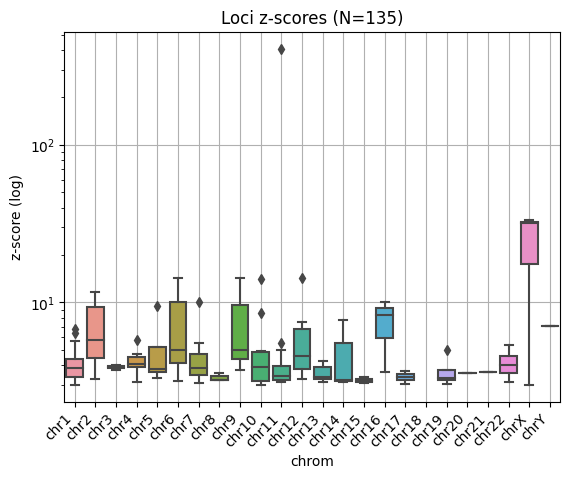

In [72]:
import seaborn as sb
import matplotlib.pyplot as plt

x_order = [f'chr{_}' for _ in list(range(1,23)) + ["X", "Y"]] # Sorting chromosomes
p = sb.boxplot(data=report, x='chrom', y="z-score", order=x_order)
plt.xticks(rotation=45, ha='right')
p.set_axisbelow(True)
plt.grid()
_ = p.set(title=f"Loci z-scores (N={len(report):,})", yscale='log', ylabel="z-score (log)")

You can see that HG002 has an expansion on chr10 that is much longer than the alleles in the control samples and that chrX has many more 'significant' expansions that other chromosomes. Chromosome X is likely explained by pseudo-autosomal regions where we failed to account for the sex of our samples. Inspecting the autosome's significant expansions in the report shows:

In [69]:
report[~report['chrom'].isin(["chrX", "chrY"])].sort_values(['z-score'], ascending=False).head()

,chrom,start,end,allele_number,allele_length,sample_name,mean,std,upper_threshold,z-score
LocusID,,,,,,,,,,
137755,chr11,50654579,50654682,2,1722,HG002,98.807692,3.997770,110.801001,406.024464
887181,chr9,79122516,79122833,3,3420,HG002,331.456731,214.922743,976.224960,14.370481
186326,chr12,70660148,70660244,2,6300,HG002,127.740385,430.053339,1417.900401,14.352312
759883,chr6,138775837,138775905,2,2798,HG002,81.336538,189.418898,649.593233,14.342093
93855,chr10,39361067,39367157,4,16575,HG002,6079.677885,744.069199,8311.885482,14.105304
